In [1]:
import os
import glob
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt4
import tensorflow as tf

### Cargar datos

In [2]:
# Descargar carpeta comprimida
file_id = "1rJlPcKCN-Sl3bL_9xoSO94NiLyyrML__"
zip_path = "data-classification.zip"
!wget -O {zip_path} "https://drive.google.com/uc?export=download&id={file_id}"

# Crear carpeta data
os.makedirs("data", exist_ok=True)

# Instalar paquetes para descomprimir
!apt-get install unrar-free

# Extraer el archivo RAR al directorio correcto
!unrar x {zip_path} data


--2025-12-03 22:25:18--  https://drive.google.com/uc?export=download&id=1rJlPcKCN-Sl3bL_9xoSO94NiLyyrML__
Resolving drive.google.com (drive.google.com)... 74.125.68.102, 74.125.68.101, 74.125.68.139, ...
Connecting to drive.google.com (drive.google.com)|74.125.68.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1rJlPcKCN-Sl3bL_9xoSO94NiLyyrML__&export=download [following]
--2025-12-03 22:25:19--  https://drive.usercontent.google.com/download?id=1rJlPcKCN-Sl3bL_9xoSO94NiLyyrML__&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.24.132, 2404:6800:4003:c03::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.24.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2428020 (2.3M) [application/octet-stream]
Saving to: ‘data-classification.zip’

data-classification 100%[===================>]   2.32M  --.-K

## Redimensionar y Dividir Train/Val

In [3]:


img_size = (224, 224)
batch_size = 32

train = tf.keras.preprocessing.image_dataset_from_directory(
    "data",
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)

val = tf.keras.preprocessing.image_dataset_from_directory(
    "data",
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)

train_ds = train.prefetch(tf.data.AUTOTUNE)
val_ds   = val.prefetch(tf.data.AUTOTUNE)

Found 391 files belonging to 2 classes.
Using 313 files for training.
Found 391 files belonging to 2 classes.
Using 78 files for validation.


## Data Augmentation

In [4]:
data_augmentation1 = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.05)
])
data_augmentation2 = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.2)
])
data_augmentation3 = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.3),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomBrightness(0.2)
])
data_augmentation4 = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.35),
    tf.keras.layers.RandomZoom(0.4),
    tf.keras.layers.RandomContrast(0.3),
    tf.keras.layers.RandomBrightness(0.3),
    tf.keras.layers.RandomTranslation(0.2, 0.2),
    tf.keras.layers.RandomShear(0.25),
    tf.keras.layers.RandomCrop(200, 200),
    tf.keras.layers.Resizing(224, 224),
    tf.keras.layers.Lambda(lambda x: x + tf.random.normal(shape=tf.shape(x), mean=0.0, stddev=8.0))
])


# Transfer Learning

## Selección Backbone

In [5]:
def build_model(backbone_name="ResNet50", augmentation=None):

    # --- Seleccionar backbone ---
    if backbone_name == "ResNet50":
        base_model = tf.keras.applications.ResNet50(
            include_top=False, input_shape=(224,224,3),
            weights="imagenet", pooling="avg"
        )
        preprocess = tf.keras.applications.resnet.preprocess_input

    elif backbone_name == "MobileNetV2":
        base_model = tf.keras.applications.MobileNetV2(
            include_top=False, input_shape=(224,224,3),
            weights="imagenet", pooling="avg"
        )
        preprocess = tf.keras.applications.mobilenet_v2.preprocess_input

    elif backbone_name == "EfficientNetB0":
        base_model = tf.keras.applications.EfficientNetB0(
            include_top=False, input_shape=(224,224,3),
            weights="imagenet", pooling="avg"
        )
        preprocess = tf.keras.applications.efficientnet.preprocess_input

    else:
        raise ValueError(f"Backbone desconocido: {backbone_name}")


    # --- Congelar el backbone (fase 1: feature extraction) ---
    base_model.trainable = False


    # --- Crear modelo  ---
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(224,224,3)),
        augmentation,
        tf.keras.layers.Lambda(preprocess),
        base_model,
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(2, activation='softmax')
    ])


    # --- Compilar ---
    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model



In [16]:
results = []

In [17]:
backbones = ["MobileNetV2", "ResNet50", "EfficientNetB0"]

for b in backbones:
    print(f"Entrenando {b} con data_augmentation1")
    model = build_model(b, data_augmentation1)

    history = model.fit(
        train,
        epochs=10,
        validation_data=val,
        verbose=1
    )
    final_acc = history.history["val_accuracy"][-1]
    results.append(["data_augmentation1", b, final_acc])
    print(f"Final accuracy: {final_acc}")



Entrenando MobileNetV2 con data_augmentation1
Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 391ms/step - accuracy: 0.6182 - loss: 0.7331 - val_accuracy: 0.7436 - val_loss: 0.5107
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.6739 - loss: 0.6138 - val_accuracy: 0.7308 - val_loss: 0.5000
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.7522 - loss: 0.5219 - val_accuracy: 0.7436 - val_loss: 0.4893
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.7627 - loss: 0.4993 - val_accuracy: 0.7949 - val_loss: 0.4739
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.7529 - loss: 0.4788 - val_accuracy: 0.8077 - val_loss: 0.4798
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.7665 - loss: 0.4398 - val_accuracy: 0.8077 - val_loss: 0.4859
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.8251 - loss: 0.4205 - val_accuracy: 0.7949 - val_loss: 0.4951
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0

In [18]:
for b in backbones:
    print(f"Entrenando {b} con data_augmentation2")
    model = build_model(b, data_augmentation2)

    history = model.fit(
        train,
        epochs=10,
        validation_data=val,
        verbose=1
    )
    final_acc = history.history["val_accuracy"][-1]
    results.append(["data_augmentation2", b, final_acc])
    print(f"Final accuracy: {final_acc}")


Entrenando MobileNetV2 con data_augmentation2
Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 272ms/step - accuracy: 0.6089 - loss: 0.7271 - val_accuracy: 0.7179 - val_loss: 0.5461
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.7105 - loss: 0.6005 - val_accuracy: 0.8077 - val_loss: 0.5179
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.7380 - loss: 0.5358 - val_accuracy: 0.7949 - val_loss: 0.5014
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.7671 - loss: 0.4962 - val_accuracy: 0.6795 - val_loss: 0.5527
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.7720 - loss: 0.4682 - val_accuracy: 0.7949 - val_loss: 0.4906
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.7857 - loss: 0.4440 - val_accuracy: 0.7949 - val_loss: 0.4924
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.8095 - loss: 0.4377 - val_accuracy: 0.7821 - val_loss: 0.5019
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0

In [19]:
for b in backbones:
    print(f"Entrenando {b} con data_augmentation3")
    model = build_model(b, data_augmentation3)

    history = model.fit(
        train,
        epochs=10,
        validation_data=val,
        verbose=1
    )
    final_acc = history.history["val_accuracy"][-1]
    results.append(["data_augmentation3", b, final_acc])
    print(f"Final accuracy: {final_acc}")


Entrenando MobileNetV2 con data_augmentation3
Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 226ms/step - accuracy: 0.4774 - loss: 1.1799 - val_accuracy: 0.6667 - val_loss: 0.6307
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.6450 - loss: 0.7100 - val_accuracy: 0.7949 - val_loss: 0.5298
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.6586 - loss: 0.6165 - val_accuracy: 0.7821 - val_loss: 0.5146
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.7241 - loss: 0.5693 - val_accuracy: 0.7821 - val_loss: 0.5008
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.7322 - loss: 0.5203 - val_accuracy: 0.7949 - val_loss: 0.4915
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.6640 - loss: 0.5899 - val_accuracy: 0.7564 - val_loss: 0.5011
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.7254 - loss: 0.5339 - val_accuracy: 0.7949 - val_loss: 0.5015
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0

In [20]:
for b in backbones:
    print(f"Entrenando {b} con data_augmentation4")
    model = build_model(b, data_augmentation4)

    history = model.fit(
        train,
        epochs=10,
        validation_data=val,
        verbose=1
    )
    final_acc = history.history["val_accuracy"][-1]
    results.append(["data_augmentation4", b, final_acc])
    print(f"Final accuracy: {final_acc}")

Entrenando MobileNetV2 con data_augmentation4
Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 238ms/step - accuracy: 0.5498 - loss: 1.1279 - val_accuracy: 0.5256 - val_loss: 0.9485
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.6316 - loss: 0.7017 - val_accuracy: 0.6923 - val_loss: 0.5518
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.6571 - loss: 0.6837 - val_accuracy: 0.7308 - val_loss: 0.5645
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.6638 - loss: 0.5836 - val_accuracy: 0.7564 - val_loss: 0.5412
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.6705 - loss: 0.6234 - val_accuracy: 0.7051 - val_loss: 0.5326
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.6377 - loss: 0.5982 - val_accuracy: 0.7564 - val_loss: 0.5346
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.7321 - loss: 0.5852 - val_accuracy: 0.7821 - val_loss: 0.5237
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 

In [21]:
import pandas as pd
df = pd.DataFrame(results, columns=["Augment", "Backbone", "Val Accuracy"])
print(df)


               Augment        Backbone  Val Accuracy
0   data_augmentation1     MobileNetV2      0.705128
1   data_augmentation1        ResNet50      0.884615
2   data_augmentation1  EfficientNetB0      0.948718
3   data_augmentation2     MobileNetV2      0.756410
4   data_augmentation2        ResNet50      0.923077
5   data_augmentation2  EfficientNetB0      0.974359
6   data_augmentation3     MobileNetV2      0.730769
7   data_augmentation3        ResNet50      0.833333
8   data_augmentation3  EfficientNetB0      0.923077
9   data_augmentation4     MobileNetV2      0.666667
10  data_augmentation4        ResNet50      0.884615
11  data_augmentation4  EfficientNetB0      0.961538


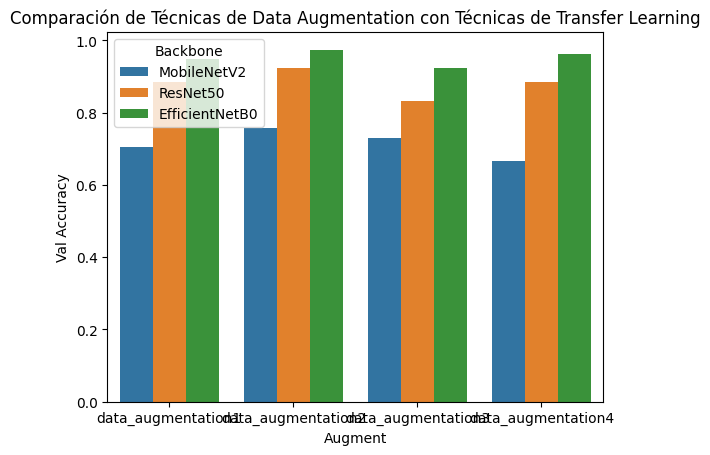

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(df, x="Augment", y="Val Accuracy", hue="Backbone")
plt.title("Comparación de Técnicas de Data Augmentation con Técnicas de Transfer Learning")
plt.show()
